#Sentiment Analysis with BERT
This notebook demonstrates the process of performing sentiment analysis using the BERT model, a state-of-the-art transformer-based architecture for natural language processing tasks. The notebook covers various stages of the machine learning pipeline, including data loading, preprocessing, model training, evaluation, and result visualization.

In [ ]:
# Import PyTorch library
import torch

# Import BERT-related classes from the transformers library
from transformers import BertTokenizer, BertForSequenceClassification

# Import PyTorch DataLoader, TensorDataset, and random_split
from torch.utils.data import DataLoader, TensorDataset, random_split

# Import AdamW optimizer and learning rate scheduler from transformers library
from transformers import AdamW, get_linear_schedule_with_warmup

# Import metrics for model evaluation from scikit-learn library
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Import seaborn and matplotlib for data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Import pandas for data manipulation and analysis
import pandas as pd

# Import train_test_split from scikit-learn for splitting dataset
from sklearn.model_selection import train_test_split

In [ ]:
# Load the sentiment analysis dataset from a CSV file using pandas
data = pd.read_csv('https://raw.githubusercontent.com/dD2405/Twitter_Sentiment_Analysis/master/train.csv')

# Shuffle the dataset to randomize the order of rows
data = data.sample(frac=1, random_state=42)


In [ ]:
data

,id,label,tweet
12227,12228,0,@user âmy mom says my smile is captivatingâ...
14709,14710,0,"in 3 days i will be meeting my sis-n-law, coun..."
19319,19320,0,hating the conservative homophobes using this ...
4308,4309,0,awee if this doesn't #scream #friday #acewe...
24055,24056,0,fathersday #fatherÃ¢ÂÂs #day #god! #ÃÂ« #...
...,...,...,...
29802,29803,0,#waltdisneyreso should be ashamed of themselv...
5390,5391,0,@user invited @user over for a catch up and i...
860,861,1,black professor makes assumptions about an ent...
15795,15796,0,#lgbtqhatetrumppay is total #liberal trash. it...


In [ ]:
# Load the BERT tokenizer with the 'bert-base-uncased' pre-trained model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the 'tweet' column of the dataset, padding and truncating sequences as needed,
# and return PyTorch tensors for inputs
inputs = tokenizer(data['tweet'].tolist(), padding=True, truncation=True, return_tensors='pt')

# Convert the 'label' column of the dataset to a PyTorch tensor
labels = torch.tensor(data['label'].tolist())


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]


input_ids:

The input_ids tensor represents the numerical indices of the tokens in a given text. Each token in the input text is mapped to a unique integer ID based on the vocabulary of the pre-trained model. In the context of BERT or similar models, this tensor is typically generated by tokenizing the input text and then converting the tokens into their corresponding IDs.

token_type_ids:

The token_type_ids tensor is used in models that can accept multiple sequences as input, such as BERT for tasks like sentence pair classification. For a single-sequence task, all values in this tensor are usually set to 0. In a two-sequence task, this tensor distinguishes between tokens from the first and second sequences by assigning different values (0 or 1) to the corresponding tokens.

attention_mask:

The attention_mask tensor is a binary mask that indicates which elements in the input_ids tensor should be attended to and which should be ignored. In other words, it helps the model focus on the actual content of the input and disregard padding tokens. The mask has a value of 1 for tokens that should be attended to and 0 for tokens that should be ignored (usually padding tokens).

In [ ]:
inputs


{'input_ids': tensor([[  101,  1030,  5310,  ...,     0,     0,     0],
        [  101,  1999,  1017,  ...,     0,     0,     0],
        [  101, 22650,  1996,  ...,     0,     0,     0],
        ...,
        [  101,  2304,  2934,  ...,     0,     0,     0],
        [  101,  1001, 12010,  ...,     0,     0,     0],
        [  101,  2054,  3084,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

137: dimension represents the length of the input sequences after tokenization. In other words, each row in the tensor corresponds to a sequence of 137 tokens.

In [ ]:
inputs['input_ids'].shape

torch.Size([31962, 137])

In [ ]:
labels.shape

torch.Size([31962])

In [ ]:
# Extract the 'input_ids' tensor from the tokenized inputs
input_ids = inputs['input_ids']

# Extract the 'attention_mask' tensor from the tokenized inputs
attention_mask = inputs['attention_mask']


In [ ]:
# Split the dataset into train/validation/test sets using train_test_split
# First, split into train and combined validation/test sets
train_input_ids, val_test_input_ids, train_attention_mask, val_test_attention_mask, train_labels, val_test_labels = train_test_split(
    input_ids, attention_mask, labels, test_size=0.2, random_state=42)

# Then, split the combined validation/test sets into separate validation and test sets
val_input_ids, test_input_ids, val_attention_mask, test_attention_mask, val_labels, test_labels = train_test_split(
    val_test_input_ids, val_test_attention_mask, val_test_labels, test_size=0.5, random_state=42)


In [ ]:
# Create PyTorch TensorDatasets for train, validation, and test sets
train_dataset = TensorDataset(train_input_ids, train_attention_mask, train_labels)
val_dataset = TensorDataset(val_input_ids, val_attention_mask, val_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_mask, test_labels)

# Create PyTorch DataLoaders for train, validation, and test sets
# Batch size is set to 32, and shuffle is enabled for the training DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# For validation and test, shuffle is disabled as order is not important during evaluation
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
# Define the number of classes (in this case, 2 for positive and negative sentiment)
num_classes = 2

# Load the pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)



model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Check if a GPU is available; if not, use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the BERT model to the specified device (CUDA/GPU or CPU)
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# Move training input data to the specified device (CUDA/GPU or CPU)
train_input_ids, train_attention_mask, train_labels = train_input_ids.to(device), train_attention_mask.to(device), train_labels.to(device)

# Move validation input data to the specified device (CUDA/GPU or CPU)
val_input_ids, val_attention_mask, val_labels = val_input_ids.to(device), val_attention_mask.to(device), val_labels.to(device)


The get_linear_schedule_with_warmup function is often used in conjunction with transformer-based models, where a warm-up phase is beneficial for stabilizing training. During the warm-up phase, the learning rate starts low and gradually increases, allowing the model to converge more smoothly. After the warm-up phase, the learning rate may continue to change linearly or follow a different schedule.

In summary, the provided code sets up a linear learning rate scheduler with no warm-up (num_warmup_steps=0) and a total number of training steps specified by total_steps. This scheduler is then typically used in the training loop to adjust the learning rate during the training process.

In [ ]:
# Set up the AdamW optimizer for model parameters with a learning rate of 2e-5 and epsilon of 1e-8
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Define the number of training epochs
epochs = 3

# Calculate the total number of training steps based on the number of batches and epochs
total_steps = len(train_dataloader) * epochs

# Set up a linear learning rate scheduler with warmup
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Training loop for the specified number of epochs
for epoch in range(epochs):
    # Set the model to training mode
    model.train()

    # Iterate over batches in the training DataLoader
    for batch in train_dataloader:
        # Move batch to the specified device (CUDA/GPU or CPU)
        batch = tuple(t.to(device) for t in batch)

        # Create a dictionary of inputs for the model
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}

        # Zero the gradients before backward pass
        optimizer.zero_grad()

        # Forward pass through the model
        outputs = model(**inputs)

        # Get the loss from the model's output
        loss = outputs.loss

        # Perform backward pass and optimization step
        loss.backward()
        optimizer.step()

        # Update the learning rate scheduler
        scheduler.step()


In [ ]:
# Set the model to evaluation mode
model.eval()

# Initialize lists to store predictions and true labels
predictions, true_labels = [], []


In [ ]:
# Use torch.no_grad() to disable gradient computation during evaluation
with torch.no_grad():
    # Iterate over batches in the validation DataLoader
    for batch in val_dataloader:
        # Move batch to the specified device (CUDA/GPU or CPU)
        batch = tuple(t.to(device) for t in batch)

        # Create a dictionary of inputs for the model (excluding labels during evaluation)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}

        # Forward pass through the model
        outputs = model(**inputs)

        # Get the logits from the model's output
        logits = outputs.logits

        # Extend the predictions list with the argmax of logits (class with the highest probability)
        predictions.extend(torch.argmax(logits, dim=1).cpu().tolist())  # Move predictions back to CPU

        # Extend the true labels list with the actual labels from the batch
        true_labels.extend(batch[2].cpu().tolist())  # Move labels back to CPU


In [ ]:
# Calculate accuracy using scikit-learn's accuracy_score
accuracy = accuracy_score(true_labels, predictions)

# Calculate confusion matrix using scikit-learn's confusion_matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Generate classification report using scikit-learn's classification_report
class_report = classification_report(true_labels, predictions)


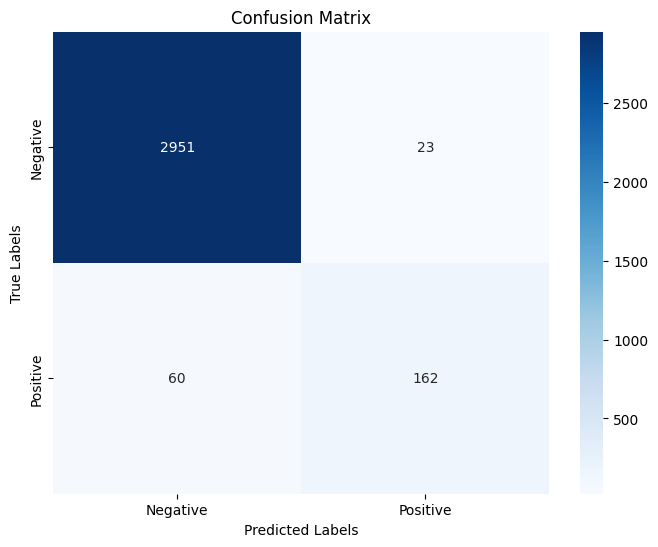

In [ ]:
# Create a heatmap of the confusion matrix using seaborn and matplotlib
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



In [ ]:
# Print the calculated accuracy
print(f'Accuracy: {accuracy}')

# Print the classification report
print('Classification Report:\n', class_report)


Accuracy: 0.9740300375469336
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      2974
           1       0.88      0.73      0.80       222

    accuracy                           0.97      3196
   macro avg       0.93      0.86      0.89      3196
weighted avg       0.97      0.97      0.97      3196



In [ ]:
# Set the model to evaluation mode
model.eval()

# Initialize lists to store test predictions and true labels
test_predictions, true_labels = [], []

# Use torch.no_grad() to disable gradient computation during evaluation
with torch.no_grad():
    # Iterate over batches in the test DataLoader
    for batch in test_dataloader:
        # Move batch to the specified device (CUDA/GPU or CPU)
        inputs = {'input_ids': batch[0].to(device), 'attention_mask': batch[1].to(device)}

        # Forward pass through the model
        outputs = model(**inputs)
        logits = outputs.logits

        # Get predictions by selecting the class with the highest probability
        predictions = torch.argmax(logits, dim=1).cpu().tolist()  # Move predictions back to CPU

        # Extend the true labels and test predictions lists with data from the batch
        true_labels.extend(batch[2].cpu().tolist())  # Move labels back to CPU
        test_predictions.extend(predictions)


In [ ]:
# Calculate accuracy, confusion matrix, and classification report for the test set
test_accuracy = accuracy_score(true_labels, test_predictions)
test_conf_matrix = confusion_matrix(true_labels, test_predictions)
test_class_report = classification_report(true_labels, test_predictions)

# Print and display results
print(f'Test Accuracy: {test_accuracy}')
print('Test Classification Report:\n', test_class_report)
print('Test Confusion Matrix:\n', test_conf_matrix)


Test Accuracy: 0.9734125742883953
Test Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      2954
           1       0.88      0.75      0.81       243

    accuracy                           0.97      3197
   macro avg       0.93      0.87      0.90      3197
weighted avg       0.97      0.97      0.97      3197

Test Confusion Matrix:
 [[2930   24]
 [  61  182]]


In [ ]:
# Iterate over batches in the test DataLoader and visualize results for a few examples
for i, batch in enumerate(test_dataloader):
    # Move batch to the specified device (CUDA/GPU or CPU)
    inputs = {'input_ids': batch[0].to(device), 'attention_mask': batch[1].to(device)}

    # Use torch.no_grad() to disable gradient computation during evaluation
    with torch.no_grad():
        # Forward pass through the model
        outputs = model(**inputs)
        logits = outputs.logits

        # Get predictions by selecting the class with the highest probability
        predictions = torch.argmax(logits, dim=1).cpu().tolist()  # Move predictions back to CPU

        # Decode the input_ids of the first example in the batch using the tokenizer
        text = tokenizer.decode(batch[0][0].cpu().numpy())

    # Print information about the example (predicted label, actual label, and text)
    print(f"Example {i + 1} - Predicted: {predictions[0]}, Actual: {batch[2][0].cpu().item()}, Text: {text}")


Example 1 - Predicted: 0, Actual: 0, Text: [CLS] i am thankful for air conditioning. # thankful # positive [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Example 2 - Predicted: 0, Actual: 0, Text: [CLS] can't wait for @ user tonight @ user @ user xxx [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD